## **Basic information**:
- There are 1941 days (5 years) of data with 0 missing values, starting on 2011-01-29 00:00:00 to 2016-05-22 00:00:00.
- There are 3049 individual products from 3 categories across 7 departments in 3 states.
- Sales demand has been increasing gradually every year.
- There are 0 missing values in sell_price data.
- Different stores have different selling prices.
- There are 7542 missing values in sell_price data.
- Four categories of events are happening throughout the year, including ('Sporting', 'Cultural', 'National', and 'Religious').
- The past lowest sale date was 2012-12-25 00:00:00 with 11 sales
- The past highest sale date was 2016-03-06 00:00:00 with 57218 sales

## Setting up the Development Environment

In [209]:
# setup development environment 
from google.colab import drive
import warnings
import logging
drive.mount('/content/drive', force_remount=True)
warnings.filterwarnings("ignore")
logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.CRITICAL)

# import libraries in Python
import pandas as pd
import numpy as np
from tqdm import tqdm
import random
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pylab as plt
import seaborn as sns
from itertools import cycle
from sklearn.preprocessing import StandardScaler

# setup working directory 
WORK_DIR = 'drive/MyDrive/TaoBin'

Mounted at /content/drive


## Exploratory Data Analysis (EDA)

In [214]:
class EDA:
  """
  EDA contains all the EDA steps to analyze data sets to summarize their main characteristics, 
  using statistical graphics and other data visualization methods.
  """

  def sales(self, sales, sell_prices,calendar):
    """
    EDA for sales data
    """

    print("------------------------------------------------- EDA for sales data -------------------------------------------------")

    # get a concise summary of the dataframe
    print(sales.info())
    print(sales.describe())

    # basic information
    days = [i for i in sales.columns.values if 'd_' in i]
    n_days = len(days) 
    n_years = len(days)//365
    date = calendar.loc[:len(days)-1, 'date']
    print(f"There are {n_days} days ({n_years} years) of data with {sales.isna().sum().sum()} missing values, starting on {date.iloc[0]} to {date.iloc[-1]}.")
    n_unique_sales = sales['item_id'].nunique()
    n_unique_departments = sales['dept_id'].nunique()
    n_unique_categories = sales['cat_id'].nunique()
    n_unique_states = sales['state_id'].nunique()
    print(f"There are {n_unique_sales} individual products from {n_unique_categories} categories across {n_unique_departments} departments in {n_unique_states} states.")
    
    # total annual sales
    date = calendar.loc[:1940,'date']
    df = pd.DataFrame({'Years':date, "Sales":sales[days].sum(axis=0).values})
    fig = px.line(data_frame=df, x="Years", y="Sales")
    fig.update_layout(title='Total Sales', title_x=0.5)
    fig.show()

    # the distribution of items in each store and category
    item_counts = sales.groupby(['store_id', 'cat_id']).agg({'item_id':'nunique'}).reset_index()
    item_counts.columns = ['store_id', 'cat_id', 'item_counts']
    fig = px.bar(item_counts, x='store_id', y='item_counts', color='cat_id');
    fig.show()
    
  def sell_prices(self, sales, sell_prices, calendar):
    """
    EDA for sell_prices data
    """

    print("------------------------------------------------- EDA for sell_prices data -------------------------------------------------")

    # get a concise summary of the dataframe
    print(sell_prices.info())
    print(sell_prices.describe())
    print(f"There are {sell_prices.isna().sum().sum()} missing values in sell_price dataframe")
    
    # take a look at given historical sale prices of each item
    color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])
    items = ['FOODS_3_375', 'HOUSEHOLD_1_248', 'HOBBIES_1_344']
    for item in items:
      fig, ax = plt.subplots(figsize=(15, 5))
      stores = []
      for store, d in sell_prices.query(f'item_id == "{item}"').groupby('store_id'):
          d.plot(x='wm_yr_wk',
                y='sell_price',
                style='.',
                color=next(color_cycle),
                figsize=(15, 5),
                title=f'{item} sale price over time',
              ax=ax,
                legend=store)
          stores.append(store)
          plt.legend()
      plt.legend(stores)
      plt.show()


  def calendar(self, sales, sell_prices, calendar):
    """
    EDA for calendar data
    """

    print("------------------------------------------------- EDA for calendar data -------------------------------------------------")

    # get a concise summary of the dataframe
    print(calendar.info())
    print(calendar.describe())
    print(f"{calendar.event_type_1.nunique()} categories of events are happening throughout the year, including {tuple(calendar.event_type_1.unique()[1:])}")
    print(f"There are {calendar.isna().sum().sum()} missing values in calendar dataframe")
    
    # the lowest sale date
    sales_train_val = pd.read_csv(f'{WORK_DIR}/raw_data/sales_train_validation.csv')
    d_cols = [c for c in sales_train_val.columns if 'd_' in c] # sales data columns
    past_sales = sales_train_val.set_index('id')[d_cols].T.merge(calendar.set_index('d')['date'],left_index=True,right_index=True,validate='1:1').set_index('date')
    print(f'The past lowest sale date was {past_sales.sum(axis=1).sort_values().index[0]} with {past_sales.sum(axis=1).sort_values().values[0]} sales')
    print(f'The past highest sale date was {past_sales.sum(axis=1).sort_values(ascending=False).index[0]} with {past_sales.sum(axis=1).sort_values(ascending=False).values[0]} sales')

------------------------------------------------- EDA for sell_prices data -------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6841121 entries, 0 to 6841120
Data columns (total 4 columns):
 #   Column      Dtype   
---  ------      -----   
 0   store_id    category
 1   item_id     category
 2   wm_yr_wk    int16   
 3   sell_price  float16 
dtypes: category(2), float16(1), int16(1)
memory usage: 45.7 MB
None
           wm_yr_wk    sell_price
count  6.841121e+06  6.841121e+06
mean   1.138294e+04           NaN
std    1.486100e+02  0.000000e+00
min    1.110100e+04  1.000214e-02
25%    1.124700e+04  2.179688e+00
50%    1.141100e+04  3.470703e+00
75%    1.151700e+04  5.839844e+00
max    1.162100e+04  1.073125e+02
There are 0 missing values in sell_price dataframe


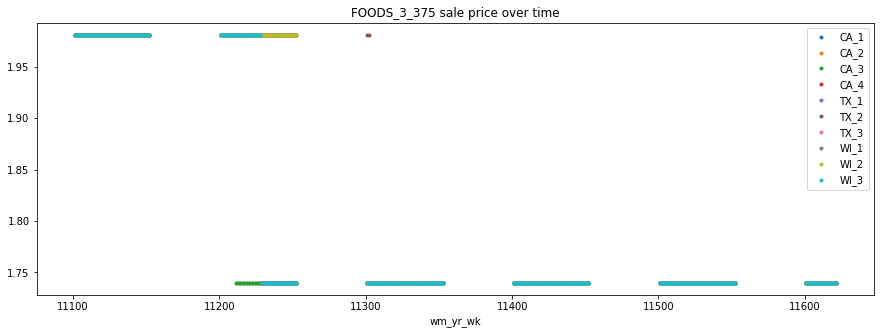

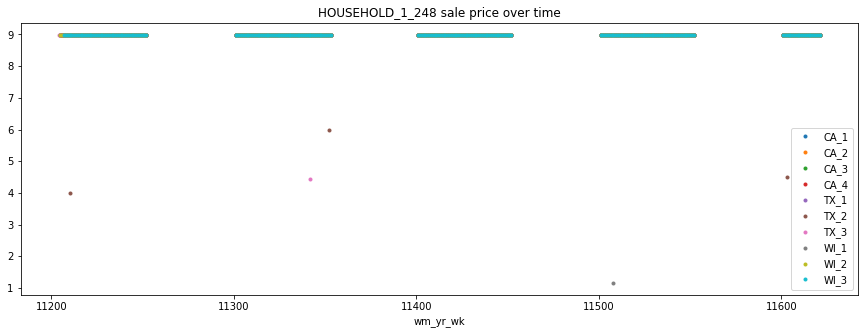

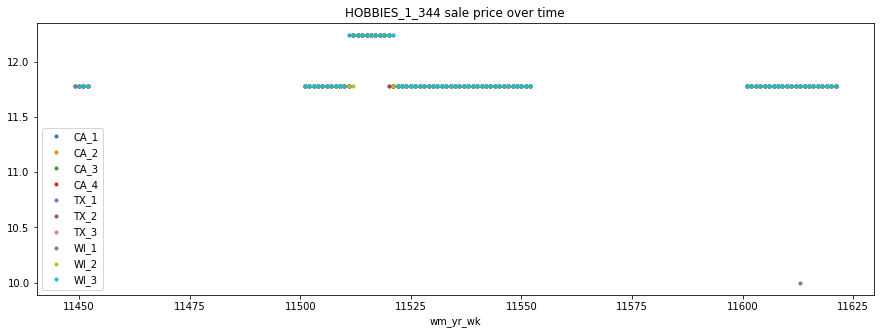

------------------------------------------------- EDA for calendar data -------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          1969 non-null   datetime64[ns]
 1   wm_yr_wk      1969 non-null   int16         
 2   weekday       1969 non-null   category      
 3   wday          1969 non-null   int8          
 4   month         1969 non-null   int8          
 5   year          1969 non-null   int16         
 6   d             1969 non-null   category      
 7   event_name_1  162 non-null    category      
 8   event_type_1  162 non-null    category      
 9   event_name_2  5 non-null      category      
 10  event_type_2  5 non-null      category      
 11  snap_CA       1969 non-null   int8          
 12  snap_TX       1969 non-null   int8          
 13  snap_WI       19

In [215]:
if __name__ == "__main__":

  # load pickled pandas object from file.
  sales = pd.read_pickle(f'{WORK_DIR}/processed_data/downcast_sales.pkl')
  sell_prices = pd.read_pickle(f'{WORK_DIR}/processed_data/downcast_sell_prices.pkl')
  calendar = pd.read_pickle(f'{WORK_DIR}/processed_data/downcast_calendar.pkl')

  eda = EDA()
  # eda.sales(sales, sell_prices, calendar)
  eda.sell_prices(sales, sell_prices, calendar)
  eda.calendar(sales, sell_prices, calendar)

  sample_op = pd.read_csv(f'{WORK_DIR}/raw_data/sample_submission.csv')
  print("------------------------------------------------- sample output -------------------------------------------------")
  print(sample_op)